# Practical assignment 3
#### Group 8: Christopher Galias (s1009417) and Robin de Heer (s4349792)

### 1. Implement an RNN and plot the training and test loss on the toy data as a function of epoch number.

First, we import the necessary libraries.

In [1]:
from __future__ import division
from __future__ import print_function
import copy

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import chainer
from chainer import Variable
from chainer import datasets, iterators, optimizers
from chainer import Chain
import chainer.functions as F
import chainer.links as L
from chainer.dataset import convert
from chainer.datasets import TupleDataset
from chainer import training
from chainer.training import extensions

We set the hyperparameters.

In [2]:
batch_size = 20
n_epochs = 100
bprop_len = 5

Next, we create the toy datasets.

In [3]:
def create_data(n=3000):

    X = np.random.rand(n, 1).astype('float32')
    T = np.sum(np.hstack((X[0:-1], X[1:])), axis=1)
    T = np.hstack([0, T[0:]]).astype('float32')
    T = T.reshape((n, 1))
    
    return TupleDataset(X, T)

In [4]:
train = create_data()
val = create_data()

What follows is a simple RNN model definition.

In [5]:
class RNN(Chain):
    def __init__(self, n_units):
        super(RNN, self).__init__()
        with self.init_scope():
            self.lstm = L.LSTM(1, n_units)    # the first LSTM layer
            self.out = L.Linear(n_units, 1)  # the feed-forward output layer

    def reset_state(self):
        self.lstm.reset_state()

    def __call__(self, x):
        # Given the current word, predict the next word.
        h = self.lstm(x)
        return self.out(h)

Next we define a regressor, as our outputs will be continuous.

In [6]:
class Regressor(Chain):
    def __init__(self, predictor):
        super(Regressor, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.mean_squared_error(y, t)
        chainer.report({'loss': loss}, self)
        return loss

Next, we define a sequential iterator suitable for our taks. The iterator is copied from [the Recurrent Net Language Model example](https://github.com/chainer/chainer/blob/master/examples/ptb/train_ptb.py) (we added the reset() method). The iterator returns a list of tuples of the current words and the next words (for the 2nd task).

In [7]:
class ParallelSequentialIterator(chainer.dataset.Iterator):
    
    def __init__(self, dataset, batch_size, repeat=True):
        self.dataset = dataset
        self.batch_size = batch_size  # batch size
        # Number of completed sweeps over the dataset. In this case, it is
        # incremented if every word is visited at least once after the last
        # increment.
        self.epoch = 0
        # True if the epoch is incremented at the last iteration.
        self.is_new_epoch = False
        self.repeat = repeat
        length = len(dataset)
        # Offsets maintain the position of each sequence in the mini-batch.
        self.offsets = [i * length // batch_size for i in range(batch_size)]
        # NOTE: this is not a count of parameter updates. It is just a count of
        # calls of ``__next__``.
        self.iteration = 0
        # use -1 instead of None internally
        self._previous_epoch_detail = -1.

    def __next__(self):
        # This iterator returns a list representing a mini-batch. Each item
        # indicates a different position in the original sequence. Each item is
        # represented by a pair of two word IDs. The first word is at the
        # "current" position, while the second word at the next position.
        # At each iteration, the iteration count is incremented, which pushes
        # forward the "current" position.
        length = len(self.dataset)
        if not self.repeat and self.iteration * self.batch_size >= length:
            # If not self.repeat, this iterator stops at the end of the first
            # epoch (i.e., when all words are visited once).
            raise StopIteration
        cur_words = self.get_words()
        self._previous_epoch_detail = self.epoch_detail
        self.iteration += 1
        next_words = self.get_words()

        epoch = self.iteration * self.batch_size // length
        self.is_new_epoch = self.epoch < epoch
        if self.is_new_epoch:
            self.epoch = epoch

        return list(zip(cur_words, next_words))

    @property
    def epoch_detail(self):
        # Floating point version of epoch.
        return self.iteration * self.batch_size / len(self.dataset)

    @property
    def previous_epoch_detail(self):
        if self._previous_epoch_detail < 0:
            return None
        return self._previous_epoch_detail
    
    def get_words(self):
        # It returns a list of current words.
        return [self.dataset[(offset + self.iteration) % len(self.dataset)]
                for offset in self.offsets]

    def serialize(self, serializer):
        # It is important to serialize the state to be recovered on resume.
        self.iteration = serializer('iteration', self.iteration)
        self.epoch = serializer('epoch', self.epoch)
        try:
            self._previous_epoch_detail = serializer(
                'previous_epoch_detail', self._previous_epoch_detail)
        except KeyError:
            # guess previous_epoch_detail for older version
            self._previous_epoch_detail = self.epoch + \
                (self.current_position - self.batch_size) / len(self.dataset)
            if self.epoch_detail > 0:
                self._previous_epoch_detail = max(
                    self._previous_epoch_detail, 0.)
            else:
                self._previous_epoch_detail = -1.
        
    def reset(self):
        self.epoch = 0
        self.is_new_epoch = False
        self.iteration = 0

We create the iterators from the toy data.

In [8]:
train_iter = ParallelSequentialIterator(train, batch_size)
val_iter = ParallelSequentialIterator(val, 1, repeat=False)

We set up the model and optimizer.

In [9]:
rnn = RNN(n_units=5)
model = Regressor(rnn)
optimizer = optimizers.SGD()
optimizer.setup(model)

Evaluation is a bit more tricky than before, hence we're going to use a custom function (based on the [custom loop version of the previous example](https://github.com/chainer/chainer/blob/master/examples/ptb/train_ptb_custom_loop.py)).

In [10]:
def evaluate(model, iter):
    model.predictor.train = False
    evaluator = model.copy()  # to use different state
    evaluator.predictor.reset_state()  # initialize state
    evaluator.predictor.train = False
    sum_loss = 0
    data_count = 0
    for batch in copy.copy(iter):
        x = np.array(batch)[:, 0, 0]
        t = np.array(batch)[:, 0, 1]
        loss = evaluator(x, t)
        sum_loss += loss.data
        data_count += 1
    model.predictor.train = True
    return float(sum_loss) / data_count

What follows is the training loop. It is based on the aforementioned example as well.

In [11]:
train_iter.reset()
val_iter.reset()

train_losses = []
val_losses = []

sum_loss = 0
count = 0
iteration = 0
while train_iter.epoch < n_epochs:
    loss = 0
    iteration += 1
    # Progress the dataset iterator for bprop_len words at each iteration.
    for i in range(bprop_len):
        batch = train_iter.__next__()
        x = np.array(batch)[:, 0, 0]
        t = np.array(batch)[:, 0, 1]
        # Compute the loss at this time step and accumulate it
        loss += optimizer.target(chainer.Variable(x), chainer.Variable(t))
        count += 1

    sum_loss += loss.data
    optimizer.target.cleargrads()  # Clear the parameter gradients
    loss.backward()  # Backprop
    loss.unchain_backward()  # Truncate the graph
    optimizer.update()  # Update the parameters
    
    if train_iter.is_new_epoch:
        val_loss = evaluate(model, val_iter)
        val_losses.append(val_loss)
        train_loss = float(sum_loss) / count
        train_losses.append(train_loss)
        
        print('epoch: ', train_iter.epoch)
        print('training loss: ', train_loss)
        print('validation loss: ', val_loss)
        rnn.reset_state()
    
    if iteration % 20 == 0:
        sum_loss = 0
        count = 0

epoch:  1
training loss:  0.156017860174
validation loss:  0.150011605007
epoch:  2
training loss:  0.136367401481
validation loss:  0.132451429072
epoch:  3
training loss:  0.116545097828
validation loss:  0.110245530791
epoch:  4
training loss:  0.0918223547935
validation loss:  0.0860099291927
epoch:  5
training loss:  0.076482194066
validation loss:  0.0745546828922
epoch:  6
training loss:  0.0669136595726
validation loss:  0.0665234309289
epoch:  7
training loss:  0.0608870363235
validation loss:  0.0596334321181
epoch:  8
training loss:  0.0540245780349
validation loss:  0.0538933482082
epoch:  9
training loss:  0.0500369769335
validation loss:  0.0491405459768
epoch:  10
training loss:  0.0452503019571
validation loss:  0.0452099496009
epoch:  11
training loss:  0.0427107670903
validation loss:  0.041963392589
epoch:  12
training loss:  0.0393339237571
validation loss:  0.0392850105578
epoch:  13
training loss:  0.0377363958955
validation loss:  0.0370766152368
epoch:  14
train

Finally, we plot the losses.

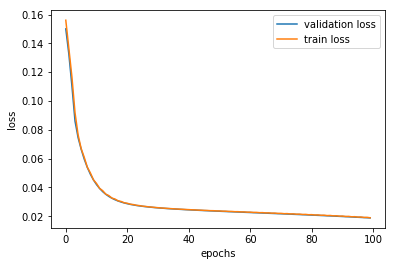

In [12]:
plt.plot(val_losses)
plt.plot(train_losses)
plt.legend(["validation loss", "train loss"])
plt.ylabel("loss")
_ = plt.xlabel("epochs")

### 2. Run your network for 100 time steps on test data; plot the predicted sum and the actual sum as a function of time.

We copy to previous model to use a new state.

In [13]:
eval_model = model.copy()  # to use different state
eval_model.predictor.reset_state()  # initialize state
predicted_sums = []
real_sums = []
for batch in copy.copy(val_iter):
    x = np.array(batch)[:, 0, 0]
    t = np.array(batch)[:, 0, 1]
    y = eval_model.predictor(x)
    predicted_sums.append(y.data.squeeze())
    real_sums.append(t.squeeze())

Finally, we plot the predicted and real sum over 100 timesteps.

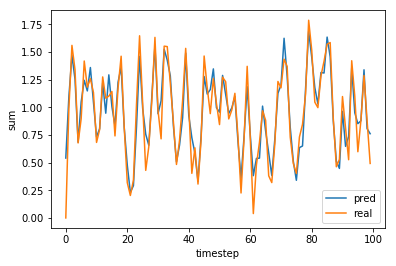

In [14]:
plt.plot(predicted_sums[:100])
plt.plot(real_sums[:100])
plt.legend(["pred", "real"])
plt.ylabel("sum")
_ = plt.xlabel("timestep")